<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8F%B0%E5%8C%96%E4%BA%8C%E9%83%A8_%E5%A6%82%E4%BD%95%E6%8F%90%E5%8D%87%E8%BD%89%E6%8F%9B%E7%8E%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.metrics import f1_score,classification_report
import warnings;warnings.simplefilter('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.read_excel('/content/drive/My Drive/台化二部/複本 操作與品管數據(20190723提供).xlsx')
data.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141入口.1,Unnamed: 10,品管數據,Unnamed: 12
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
2,2013-08-20 10:10:00,31.212,24.9928,169.894,NaN,167.057,166.569,166.279,165.041,NaN,12.297,NaN,NaN
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,NaN,167.051,166.576,166.26,164.97,NaN,12.2914,NaN,NaN
4,2013-08-20 10:30:00,31.5726,25.163,169.526,NaN,167.042,166.584,166.235,164.877,NaN,12.3175,NaN,NaN


# 轉換成表格數據

In [0]:
def clean(data):
  data = data.dropna(how='all')
  columns = data.iloc[1,:]
  data = data.iloc[2:,:]
  data.columns = columns
  data = data.set_index('DATE')
  data.columns.name = None
  for col in data.columns:
    data[col] = pd.to_numeric(data[col],errors='coerce')
  return data

In [4]:
data = clean(data)
data.head()

,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
DATE,,,,,,,,,,,,
2013-08-20 10:10:00,31.212050,24.992781,169.893986,NaN,167.057086,166.569303,166.278953,165.041317,NaN,12.297010,NaN,NaN
2013-08-20 10:20:00,31.223557,25.066836,169.752653,NaN,167.050706,166.575684,166.259814,164.969540,NaN,12.291411,NaN,NaN
2013-08-20 10:30:00,31.572592,25.163049,169.525828,NaN,167.042458,166.583934,166.235069,164.876743,NaN,12.317545,NaN,NaN
2013-08-20 10:40:00,31.886214,25.136713,169.316875,NaN,167.034209,166.592183,166.210325,164.783946,NaN,12.317918,NaN,NaN
2013-08-20 10:50:00,31.855439,25.220729,169.665105,NaN,167.025961,166.600433,166.185580,164.691149,NaN,12.315540,NaN,NaN


In [5]:
features = data.drop(['DIPB轉化率'],axis=1).columns.tolist()
print(features)

['PHL-DCS-FIC1147_PV', 'PHL-DCS-FIC1149A_PV', 'PHL-DCS-TIC1163_PV', 'PHL-DCS-PI1162_PV', 'PHL-DCS-TI1166_PV', 'PHL-DCS-TI1167_PV', 'PHL-DCS-TI1168_PV', 'PHL-DCS-TI1169_PV', 'PHL-DCS-TI1170_PV', 'PHL-DCS-PIC1166_PV', 'T121 EB含量']


# 統計資訊

In [6]:
data.describe().style.background_gradient()

,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
count,82957,82957,82957,35751,82957,82957,82957,82957,35752,82957,1558,488
mean,33.274,22.7352,165.898,14.4079,157.729,157.846,157.635,156.099,164.57,11.3938,97.086,60.077
std,11.0211,6.74096,16.8214,0.130853,36.0506,36.1358,36.0933,36.585,6.07906,3.14274,25.0894,14.7273
min,0.0305995,0,110.036,7.40588,17.4919,17.2973,17.1474,0,54.7927,0,8,-44.0188
25%,31.1159,24.1729,168.804,14.3798,165.681,165.378,165.01,163.469,164.389,12.2974,83,59.0956
50%,35.1648,24.8027,170.478,14.4238,167.544,167.692,167.44,166.494,165.373,12.2997,94,64.217
75%,40.9854,25.4955,173.021,14.4401,170.294,170.671,170.388,169.366,166.366,12.3019,105,67.8935
max,52.7277,29.7189,184.354,15.1049,182.3,177.282,187.304,176.017,173.644,12.7299,283,72.9913


# 視覺化探索數據

PHL-DCS-FIC1147_PV


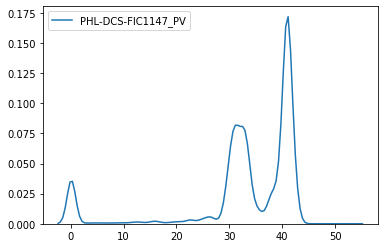

PHL-DCS-FIC1149A_PV


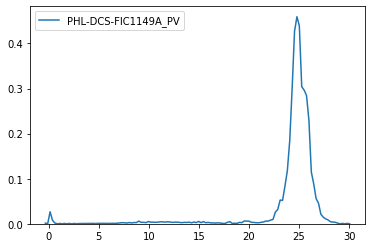

PHL-DCS-TIC1163_PV


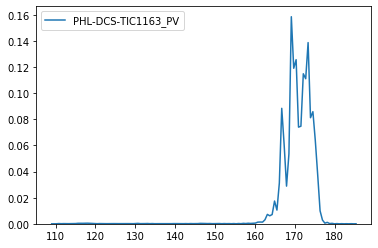

PHL-DCS-PI1162_PV


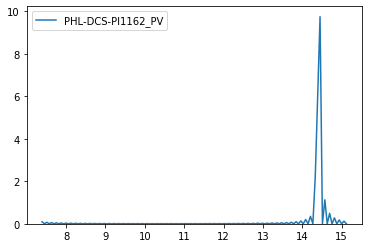

PHL-DCS-TI1166_PV


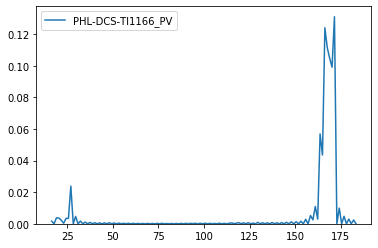

PHL-DCS-TI1167_PV


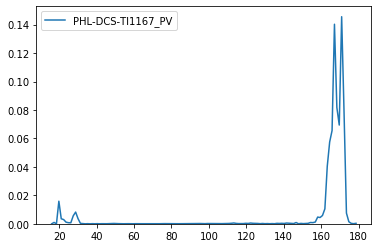

PHL-DCS-TI1168_PV


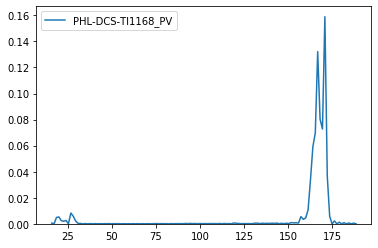

PHL-DCS-TI1169_PV


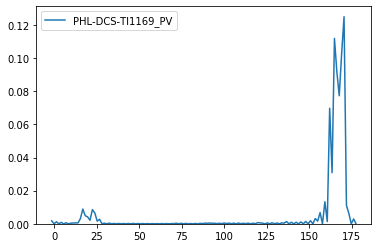

PHL-DCS-TI1170_PV


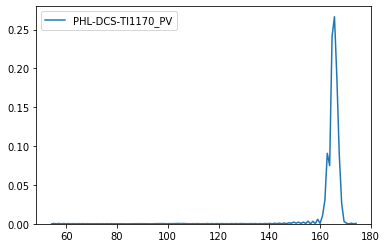

PHL-DCS-PIC1166_PV


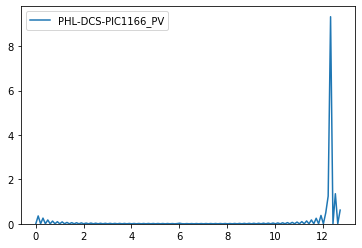

T121 EB含量


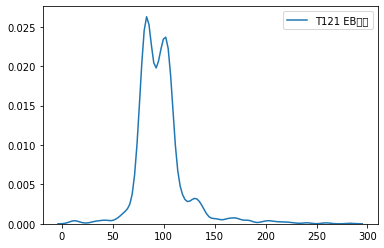

DIPB轉化率


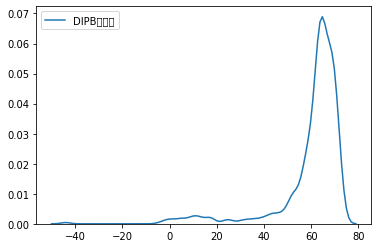

In [7]:
for col in data.columns:
  sns.kdeplot(data[col])
  print(col)
  plt.show()

# scatter

PHL-DCS-FIC1147_PV


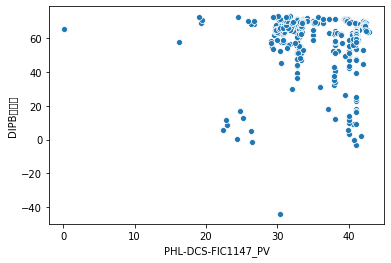

PHL-DCS-FIC1149A_PV


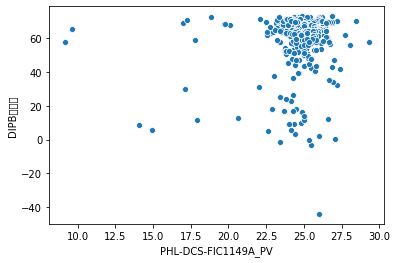

PHL-DCS-TIC1163_PV


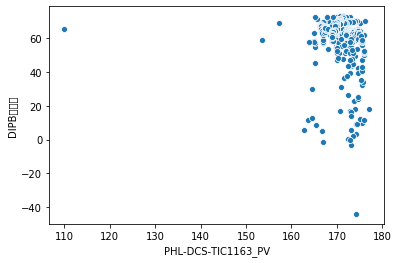

PHL-DCS-PI1162_PV


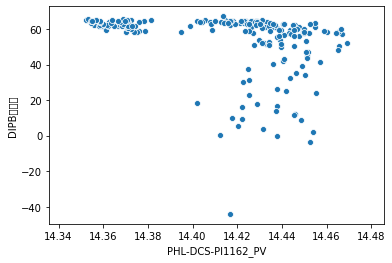

PHL-DCS-TI1166_PV


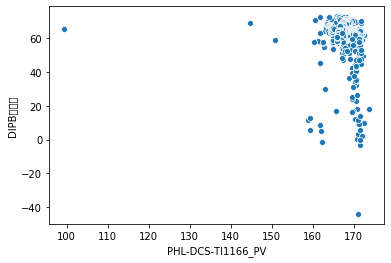

PHL-DCS-TI1167_PV


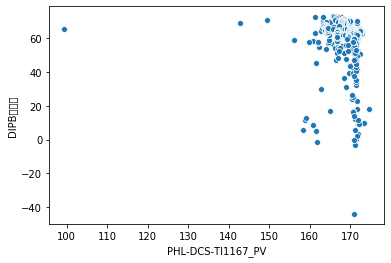

PHL-DCS-TI1168_PV


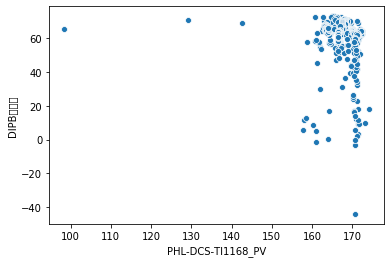

PHL-DCS-TI1169_PV


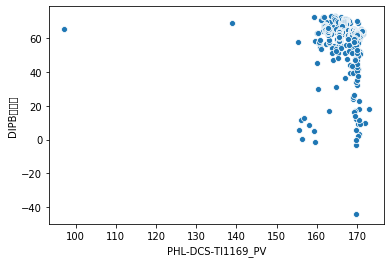

PHL-DCS-TI1170_PV


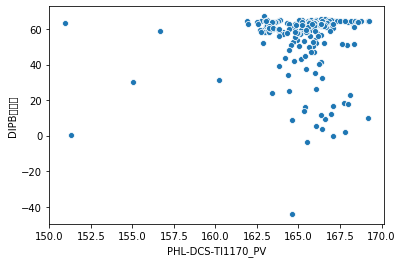

PHL-DCS-PIC1166_PV


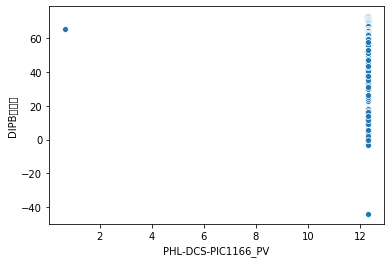

T121 EB含量


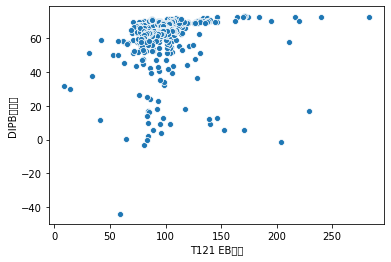

DIPB轉化率


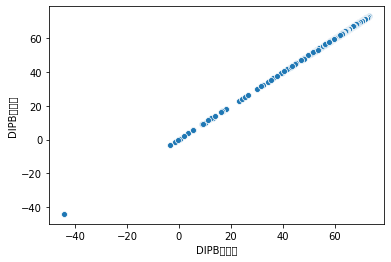

In [8]:
import seaborn as sns
for col in data.columns:
  sns.scatterplot(x=col,y='DIPB轉化率',data=data)
  print(col)
  plt.show()

# corr

In [9]:
print('經過絕對值轉換')
abs(data.corr()).style.background_gradient()

經過絕對值轉換


,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
PHL-DCS-FIC1147_PV,1,0.884923,0.89913,0.304174,0.849823,0.847297,0.841579,0.862173,0.73121,0.844226,0.23428,0.0443793
PHL-DCS-FIC1149A_PV,0.884923,1,0.934985,0.365651,0.877757,0.868036,0.859819,0.882931,0.683053,0.880731,0.0201724,0.121691
PHL-DCS-TIC1163_PV,0.89913,0.934985,1,0.350941,0.94357,0.932389,0.923426,0.939352,0.604921,0.947079,0.0629258,0.156108
PHL-DCS-PI1162_PV,0.304174,0.365651,0.350941,1,0.309391,0.262835,0.297407,0.274725,0.325315,0.962897,0.261149,0.321703
PHL-DCS-TI1166_PV,0.849823,0.877757,0.94357,0.309391,1,0.991727,0.984078,0.978121,0.648831,0.940254,0.0662891,0.128274
PHL-DCS-TI1167_PV,0.847297,0.868036,0.932389,0.262835,0.991727,1,0.994928,0.986913,0.689236,0.943591,0.082717,0.13459
PHL-DCS-TI1168_PV,0.841579,0.859819,0.923426,0.297407,0.984078,0.994928,1,0.991156,0.789451,0.941671,0.0921779,0.116291
PHL-DCS-TI1169_PV,0.862173,0.882931,0.939352,0.274725,0.978121,0.986913,0.991156,1,0.916927,0.959771,0.100037,0.096656
PHL-DCS-TI1170_PV,0.73121,0.683053,0.604921,0.325315,0.648831,0.689236,0.789451,0.916927,1,0.350758,0.291141,0.053617
PHL-DCS-PIC1166_PV,0.844226,0.880731,0.947079,0.962897,0.940254,0.943591,0.941671,0.959771,0.350758,1,0.0576365,0.0165576


# DIPB如何被PHL-DCS-PI1162_PV影響

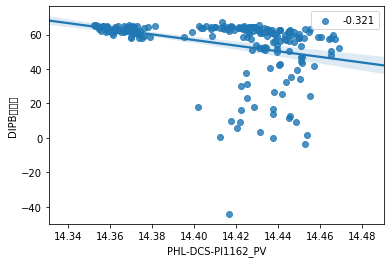

In [10]:
p = str(data[['PHL-DCS-PI1162_PV','DIPB轉化率']].corr().loc['PHL-DCS-PI1162_PV','DIPB轉化率'])[:6]
sns.regplot(data['PHL-DCS-PI1162_PV'],data['DIPB轉化率'],label=p)
plt.legend()

# kdeplot

整體DIPB轉化率平均值: 60.07697598101304
高 PHL-DCS-PI1162_PV DIPB轉化率平均值: 48.336528716017774
低 PHL-DCS-PI1162_PV DIPB轉化率平均值: 62.65855590298499


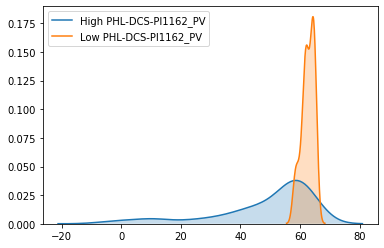

In [11]:
c1 = data['PHL-DCS-PI1162_PV']>data['PHL-DCS-PI1162_PV'].quantile(0.75)#大於75百分位數
c2 = data['PHL-DCS-PI1162_PV']<data['PHL-DCS-PI1162_PV'].quantile(0.25)#小於25百分位數
data1 = data.loc[c1,'DIPB轉化率']
data2 = data.loc[c2,'DIPB轉化率']
print('整體DIPB轉化率平均值:',np.mean(data['DIPB轉化率']))
print('高','PHL-DCS-PI1162_PV','DIPB轉化率平均值:',np.mean(data1))
print('低','PHL-DCS-PI1162_PV','DIPB轉化率平均值:',np.mean(data2))
sns.kdeplot(data1,label='High PHL-DCS-PI1162_PV',shade=True)
sns.kdeplot(data2,label='Low PHL-DCS-PI1162_PV',shade=True)

# prepare data for modeling

In [0]:
data = data[['PHL-DCS-PI1162_PV','DIPB轉化率']]
data = data.dropna()
X = data[['PHL-DCS-PI1162_PV']]
y = data['DIPB轉化率']>data['DIPB轉化率'].median()
y = y.astype(int)

In [13]:
print(X.shape,y.shape)

(212, 1) (212,)


In [14]:
y.value_counts()

1    106
0    106
Name: DIPB轉化率, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(148, 1) (148,)
(64, 1) (64,)


# modeling

In [16]:
model = LGBMClassifier(max_depth=1)
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# metric

In [17]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68        31
           1       0.69      0.88      0.77        33

    accuracy                           0.73        64
   macro avg       0.75      0.73      0.73        64
weighted avg       0.75      0.73      0.73        64



# plot tree

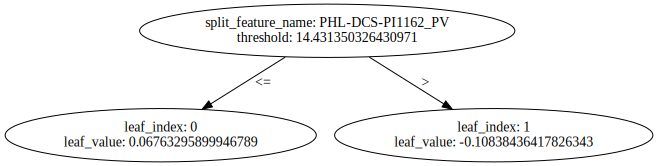

In [18]:
graph = lightgbm.create_tree_digraph(model,tree_index=3)
graph

In [19]:
graph.render(view=True)

'Digraph.gv.pdf'